# I. Tutorial

In section I., the code cells are following the tutorial described here:

https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html

#### 1. Theory

Why is it beneficial to deal with windows instead of the whole raster data?
- We can work on rasters which are larger than the computer's RAM.
- Windows of a raster can be processed parallel.

What is a window?
- It is a view onto a rectangular subset of a raster dataset.

How is a window descibed?
- In **rasterio**: column and row offsets and width and height in pixels (ints or floats in this case).
- Possible to describe from **numpy** array index tuples or **slice** objects (only int values in this case).

#### 2. Reading

In [76]:
import rasterio
import numpy as np
from PIL import Image
from matplotlib import pyplot
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.crs import CRS
from rasterio.windows import get_data_window

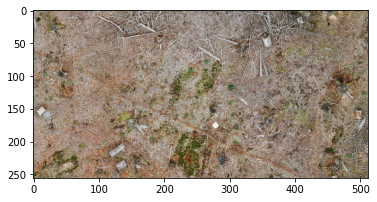

In [71]:
with rasterio.open('../Images/Orthomosaics/ortho-50mm.tif') as src:
    window = src.read(window=Window(1024, 1024, 512, 256))

show(window)

#### 3. Writing

In [20]:
# Create a numpy array with value 127
image = np.ones((150, 250), dtype=rasterio.ubyte) * 127

# Write this array into a blank raster file which has dimensions of 500x300
# Result raster file is deleted
with rasterio.open(
        '/home/habrami/Documents/HBRS-RnD/Sources/example.tif', 'w',
        driver='GTiff', width=500, height=300, count=1,
        dtype=image.dtype) as dst:
    dst.write(image, window=Window(50, 30, 250, 150), indexes=1)

#### 4. Data windows
Documentation: https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html
 
- *get_data_window* function returns with a window covering the input array’s valid data pixels.

In this case, it removed many pixels whole around the raster (probably extremas) causing a bit noisy appearance.

In [34]:
with rasterio.open('../Images/Orthomosaics/ortho-50mm.tif') as src:
    window = get_data_window(src.read())

    kwargs = src.meta.copy()
    kwargs.update({
        'height': window.height,
        'width': window.width,
        'transform': rasterio.windows.transform(window, src.transform)})

    with rasterio.open('../Images/Rasterio_windowing/cropped.tif', 'w', **kwargs) as dst:
        dst.write(src.read(window=window))

#### 5. Window transforms

A dataset’s transform is an affine transformation matrix that maps pixel locations in (row, col) coordinates to (x, y) spatial positions.

In [36]:
win = Window(256, 256, 128, 128)
with rasterio.open('../Images/Orthomosaics/ortho-50mm.tif') as src:
    src_transform = src.transform
    win_transform = src.window_transform(win)

print(src_transform)
print(win_transform)

| 0.05, 0.00, 435124.10|
| 0.00,-0.05, 5699730.59|
| 0.00, 0.00, 1.00|
| 0.05, 0.00, 435136.90|
| 0.00,-0.05, 5699717.79|
| 0.00, 0.00, 1.00|


#### 6. Window utilities

Union and intersection operations can be performed on windows.
- In this example, I see how the offset values are (10, 10) and the width value is 490. I don't see how the height value is equal to 490, I think it supposed to be 400.

In [52]:
from rasterio import windows

window1 = Window(10, 100, 490, 400)
window2 = Window(50, 10, 200, 140)
windows.union(window1, window2)

Window(col_off=10, row_off=10, width=490, height=490)

The operations (union and intersection) are performable only on raterio window objects, not on numpy arrays. As a consequence, if one wants to display the resulting windows, they should perform the operation on rasterio window objects first, and using the resulting window to read a numpy array from the orthomosaic.

In [65]:
with rasterio.open('../Images/Orthomosaics/ortho-50mm.tif') as src:
    # Read into numpy arrays to display them
    window1 = src.read(window=Window(1000, 100, 490, 400))
    window2 = src.read(window=Window(1000, 10, 200, 1400))

# Perform the operations on rasterio windows
win1 = Window(1000, 100, 490, 400)
win2 = Window(1000, 10, 200, 140)
window3 = windows.union(win1, win2)
window4 = windows.intersection(win1, win2)

with rasterio.open('../Images/Orthomosaics/ortho-50mm.tif') as src:
    # Read the resulting windows into numpy arrays to display them
    window3 = src.read(window=Window(window3.col_off, window3.row_off, window3.width, window3.height))
    window4 = src.read(window=Window(window4.col_off, window4.row_off, window4.width, window4.height))

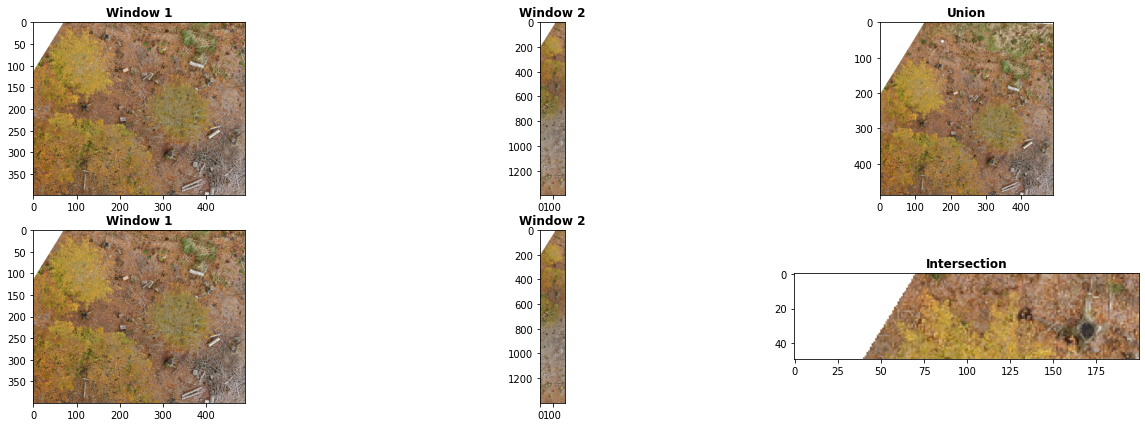

In [70]:
# Display union and intersection
fig, ((p_11, p_12, p_13), (p_21, p_22, p_23)) = pyplot.subplots(nrows=2, ncols=3, figsize=(21,7))
show(window1, ax=p_11, title='Window 1')
show(window2, ax=p_12, title='Window 2')
show(window3, ax=p_13, title='Union')
show(window1, ax=p_21, title='Window 1')
show(window2, ax=p_22, title='Window 2')
show(window4, ax=p_23, title='Intersection')
pyplot.show()

#### 7. Blocks

Raster datasets are generally composed of multiple blocks of data. The most efficient way to manipulate these rasters is to use the same block size as the blocks it is composed of.

How to read the raster's block size:

In [72]:
with rasterio.open('../Images/Orthomosaics/ortho-50mm.tif') as src:
    for i, shape in enumerate(src.block_shapes, 1):
        print((i, shape))

(1, (256, 256))
(2, (256, 256))
(3, (256, 256))


# II. Tiling the orthomosaic

In section II., an orthomosaic is splitted into blocks and these blocks are saved as images.

In [93]:
with rasterio.open('../Images/Orthomosaics/ortho-50mm.tif') as src:
    for ji, window in src.block_windows(1):
        # Read the block into a numpy array
        # Use the block's dimensions to optimize the splitting operation
        win = src.read(window=window)

        # Change the axes, otherwise it yields a weird flat image
        win = np.moveaxis(win, 0, -1)

        # Save the array as an image
        file = Image.fromarray(win, 'RGB')
        file.save('../Images/Rasterio_windowing/' + str(ji[0]) + '_' + str(ji[1]) + '.png')
            